### Базовый код

In [1]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
import seaborn as sns
from tqdm import tqdm
import time
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch import optim
from torch.optim import lr_scheduler
from IPython.display import clear_output
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

sns.set(style='darkgrid', font_scale=1.3, palette='Set2')

%matplotlib inline

In [2]:
device = f'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

В базовом коде не будем учитывать пространственные зависимости между данными.

In [3]:
with open('data.json') as file:
    data = json.load(file)

In [4]:
data_list = []
for key in data:
    data_list += data[key]['data']
    
df = pd.DataFrame(data_list)
df['date'] = pd.to_datetime(df['date'])
df.head()

,postId,date,version,temperature,pressure,humidity,pm2,pm10,aqi,co,no2,so2,o3,h2s
0,291,2022-01-01 00:00:00+00:00,1640995307000432,-4.046667,732.1188,100.0,42.566666,58.050000,"{'cityairAqi': {}, 'instantAqi': {}, 'epaAqi':...",NaN,NaN,NaN,NaN,NaN
1,291,2022-01-01 01:00:00+00:00,1640998966000214,-3.731833,731.7606,100.0,29.016666,41.716667,"{'cityairAqi': {}, 'instantAqi': {}, 'epaAqi':...",NaN,NaN,NaN,NaN,NaN
2,291,2022-01-01 02:00:00+00:00,1641002400000863,-3.322333,731.4838,100.0,19.283333,26.583334,"{'cityairAqi': {}, 'instantAqi': {}, 'epaAqi':...",NaN,NaN,NaN,NaN,NaN
3,291,2022-01-01 03:00:00+00:00,1641006021000796,-3.049667,731.3568,100.0,16.183332,22.033333,"{'cityairAqi': {}, 'instantAqi': {}, 'epaAqi':...",NaN,NaN,NaN,NaN,NaN
4,291,2022-01-01 04:00:00+00:00,1641009643000509,-2.973559,731.2467,100.0,17.016949,23.576271,"{'cityairAqi': {}, 'instantAqi': {}, 'epaAqi':...",NaN,NaN,NaN,NaN,NaN


Посмотрим, каких данных у нас нет.

In [5]:
df.isna().sum()

postId           0
date             0
version          0
temperature      0
pressure         0
humidity         0
pm2              0
pm10             0
aqi              0
co             290
no2            290
so2            870
o3             290
h2s            870
dtype: int64

Пока просто избавимся от всех колонок с отсутствующими данными.

In [7]:
df.drop(columns=['version', 'aqi', 'co', 'no2', 'so2', 'o3', 'h2s'], inplace=True)
df

,postId,date,temperature,pressure,humidity,pm2,pm10
0,291,2022-01-01 00:00:00+00:00,-4.046667,732.11880,100.000000,42.566666,58.050000
1,291,2022-01-01 01:00:00+00:00,-3.731833,731.76060,100.000000,29.016666,41.716667
2,291,2022-01-01 02:00:00+00:00,-3.322333,731.48380,100.000000,19.283333,26.583334
3,291,2022-01-01 03:00:00+00:00,-3.049667,731.35680,100.000000,16.183332,22.033333
4,291,2022-01-01 04:00:00+00:00,-2.973559,731.24670,100.000000,17.016949,23.576271
...,...,...,...,...,...,...,...
1590,490,2022-01-06 20:00:00+00:00,-1.297833,735.54600,84.760330,8.700000,9.700000
1591,490,2022-01-06 21:00:00+00:00,-1.279500,735.64630,83.895836,9.066667,9.800000
1592,490,2022-01-06 22:00:00+00:00,-1.106333,735.72394,82.471500,8.700000,9.433333
1593,490,2022-01-06 23:00:00+00:00,-1.088305,735.90980,81.479660,7.508474,8.135593


In [8]:
df.date.min(), df.date.max()

(Timestamp('2022-01-01 00:00:00+0000', tz='UTC'),
 Timestamp('2022-01-07 00:00:00+0000', tz='UTC'))

У нас имееются данные за неделю. Как видим, прогнозы почасовые. Пока оставим только показания датчика с $id = 291$.

In [9]:
df291 = df[df['postId'] == 291]
df291

,postId,date,temperature,pressure,humidity,pm2,pm10
0,291,2022-01-01 00:00:00+00:00,-4.046667,732.11880,100.000000,42.566666,58.050000
1,291,2022-01-01 01:00:00+00:00,-3.731833,731.76060,100.000000,29.016666,41.716667
2,291,2022-01-01 02:00:00+00:00,-3.322333,731.48380,100.000000,19.283333,26.583334
3,291,2022-01-01 03:00:00+00:00,-3.049667,731.35680,100.000000,16.183332,22.033333
4,291,2022-01-01 04:00:00+00:00,-2.973559,731.24670,100.000000,17.016949,23.576271
...,...,...,...,...,...,...,...
140,291,2022-01-06 20:00:00+00:00,-2.016667,728.51280,99.232330,6.750000,8.566667
141,291,2022-01-06 21:00:00+00:00,-2.035000,728.61220,99.375170,7.433333,10.533334
142,291,2022-01-06 22:00:00+00:00,-1.878667,728.69480,98.809000,7.550000,11.333333
143,291,2022-01-06 23:00:00+00:00,-1.727500,728.98895,95.130165,6.950000,9.433333


In [10]:
features_considered = ['temperature', 'pressure', 'humidity', 'pm2', 'pm10']
features = df291[features_considered]
features.index = df291['date']
features.head()

,temperature,pressure,humidity,pm2,pm10
date,,,,,
2022-01-01 00:00:00+00:00,-4.046667,732.1188,100.0,42.566666,58.050000
2022-01-01 01:00:00+00:00,-3.731833,731.7606,100.0,29.016666,41.716667
2022-01-01 02:00:00+00:00,-3.322333,731.4838,100.0,19.283333,26.583334
2022-01-01 03:00:00+00:00,-3.049667,731.3568,100.0,16.183332,22.033333
2022-01-01 04:00:00+00:00,-2.973559,731.2467,100.0,17.016949,23.576271


Данные будем делить в отношении 7:3 по временной шкале. Первая часть относится к обучающим данным, вторая - к тестовым.

In [11]:
TRAIN_SPLIT = int(0.7 * len(features))

train = features[:TRAIN_SPLIT]
test = features[TRAIN_SPLIT:]

Выполним нормализацию данных.

In [12]:
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train)
test_data_normalized = scaler.transform(test)

Для обучения нужно создать датасет, который будет возвращать последовательность из $\tau$ элементов временного ряда для обучения и следующий за ними $(\tau+1)$-элемент как таргет. Для этого мы создадим класс-наследник от класса `Dataset`.

In [13]:
class TSDataset(Dataset):
    def __init__(self, data, n_past):
        self.data = data
        self.n_past = n_past  # tau -- длина отрезка временого ряда

    def __len__(self):
        return self.data.shape[0] - self.n_past

    def __getitem__(self, index):
        return self.data[index: self.n_past + index], self.data[self.n_past + index]

Модель будет смотреть в прошлое на $\tau$ измерений. В данных одному дню соответствует $24$ измерения, поэтому возьмем $\tau=24$.

In [16]:
n_past = 24  # tau -- длина отрезка временого ряда
batch_size = 32  # размер батча

train_dataset = TSDataset(train_data_normalized, n_past)
train_batch_gen = DataLoader(train_dataset, batch_size, shuffle=False)

Пайплайн обучения:

In [17]:
def plot_learning_curves(history):
    '''
    Функция для вывода лосса во время обучения.

    :param history: (dict)
        loss на обучении.
    '''

    fig = plt.figure(figsize=(10, 5))
    plt.plot(history['loss'])
    plt.ylabel('Лосс')
    plt.xlabel('Эпоха')
    plt.show()


def evaluate_ts_model(model, start_seq, test_data):
    '''
    Функция для проверки качества модели на тестовом отрезке ряда.

    :param model: обучаемая модель,
    :param start_seq: обучающие данные для первого предсказания,
    :param test_data: тестовые данные.

    :return: результаты предсказания.
    '''
    result = []

    input_tensor = torch.FloatTensor(start_seq).to(device).unsqueeze(0)
    with torch.no_grad():
        for i in range(len(test_data)):
            logits = model(input_tensor[:, i:, :]).unsqueeze(0)
            input_tensor = torch.cat((input_tensor, logits), 1)
            result.append(logits.cpu().numpy().squeeze())
    return result


def plot_ts_results(y_pred, y_true, train_split, title, lw=2):
    '''
    Визуализирует результаты прогнозирования

    :param y_pred: прогнозы
    :param y_true: истинные значения
    :param train_split: индекс для разделения данных на трейн и тест
    :param title: название
    :param lw: толщина линии
    '''
    plt.figure(figsize=(18, 8))

    plt.plot(features.index, features[y_true], label='Истина', lw=lw)
    plt.plot(features.index[train_split:], y_pred, label='Предсказание', lw=lw)

    plt.title(title)
    plt.xlabel('Время')
    plt.ylabel(y_true)
    plt.legend()
    plt.show()


def train_ts_model(
    model,
    criterion,
    optimizer,
    train_batch_gen,
    num_epochs=50,
):
    '''
    Функция для обучения модели и вывода лосса во время обучения.

    :param model: обучаемая модель
    :param criterion: функция потерь
    :param optimizer: метод оптимизации
    :param train_batch_gen: генератор батчей для обучения
    :param num_epochs: количество эпох

    :return: обученная модель
    :return: (dict) loss на обучении ('история' обучения)
    '''

    history = defaultdict(list)

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0

        start_time = time.time()

        # Устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True)

        # На каждой 'эпохе' делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            X_batch = X_batch.type('torch.FloatTensor').to(device)
            y_batch = y_batch.type('torch.FloatTensor').to(device)

            logits = model(X_batch)

            loss = criterion(logits, y_batch)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += np.sum(loss.detach().cpu().numpy())

        # Подсчитываем лосс и сохраням в 'историю'
        train_loss /= len(train_batch_gen)
        history['loss'].append(train_loss)

        clear_output()

        # Печатаем результаты после каждой эпохи
        print('Эпоха {} из {} выполнена за {:.3f} сек.'.format(
            epoch + 1, num_epochs, time.time() - start_time))
        print('  лосс: \t{:.6f}'.format(train_loss))
        plot_learning_curves(history)

    return model, history

Напишем однослойную LSTM.

In [18]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=100):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size, batch_first=True)
        self.linear = nn.Linear(in_features=hidden_size,
                                out_features=output_size)

    def forward(self, input_seq):
        lstm_out, (hidden_state, _) = self.lstm(input_seq)
        predictions = self.linear(hidden_state.squeeze(0))
        return predictions

Объявляем и обучаем модель.

In [19]:
lstm_model = LSTM(input_size=5, output_size=5)
lstm_model.to(device)

LSTM(
  (lstm): LSTM(5, 100, batch_first=True)
  (linear): Linear(in_features=100, out_features=5, bias=True)
)

Эпоха 100 из 100 выполнена за 0.018 сек.
  лосс: 	0.015675


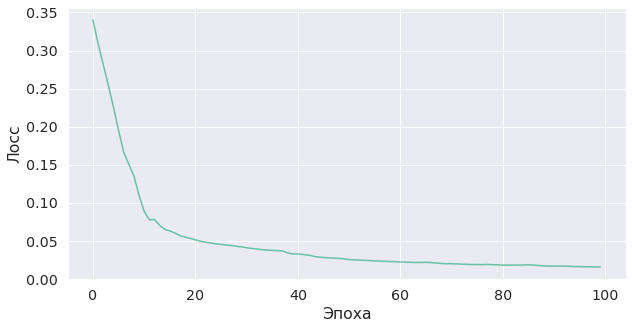

In [20]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-3)

lstm_model, _ = train_ts_model(lstm_model, criterion, optimizer, train_batch_gen, num_epochs=100);

Получаем результаты на тестовых данных.

In [21]:
start_seq = train_data_normalized[-n_past:]
lstm_result = evaluate_ts_model(lstm_model, start_seq, test_data_normalized)

Применяем обратное преобразование к результатам, чтобы убрать нормализацию.

In [22]:
lstm_result = np.array(lstm_result, ndmin=2)
lstm_result = scaler.inverse_transform(lstm_result)

Подсчитываем ошибку предсказания концентрации PM2 и визуализируем результаты.

In [23]:
true_pm2 = test['pm2']
pred_pm2 = lstm_result[:, -2]
rmse = mean_squared_error(true_pm2, pred_pm2, squared=False)
print('RMSE на тестовых данных для PM2 = {:.3f}'.format(rmse))

RMSE на тестовых данных для PM2 = 11.769


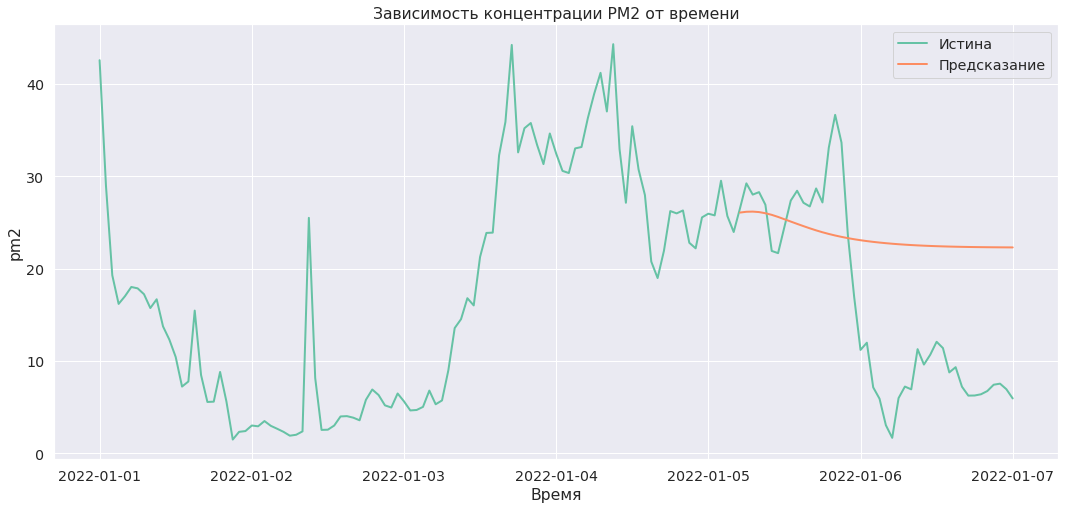

In [24]:
title = 'Зависимость концентрации PM2 от времени'
label = 'pm2'

plot_ts_results(pred_pm2, label, TRAIN_SPLIT, title)

Подсчитываем ошибку предсказания концентрации PM10 и визуализируем результаты.

In [25]:
true_pm10 = test['pm10']
pred_pm10 = lstm_result[:, -1]
rmse = mean_squared_error(true_pm10, pred_pm10, squared=False)
print('RMSE на тестовых данных для PM10 = {:.3f}'.format(rmse))

RMSE на тестовых данных для PM10 = 21.374


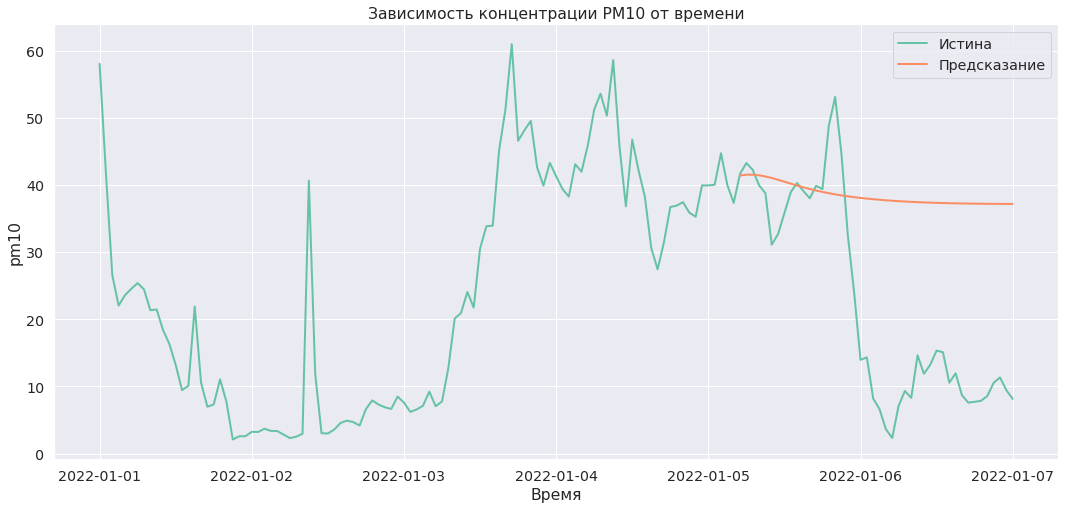

In [26]:
title = 'Зависимость концентрации PM10 от времени'
label = 'pm10'

plot_ts_results(pred_pm10, label, TRAIN_SPLIT, title)